<a href="https://colab.research.google.com/github/Dennis-Rotich/Customer_support_analyzer/blob/main/Analyzing_customer_support_calls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

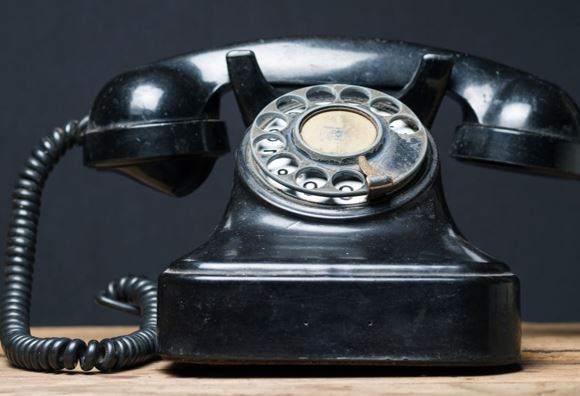

A retail company is on a transformative journey, aiming to elevate their customer services through cutting-edge advancements in Speech Recognition and Natural Language Processing (NLP). As the machine learning engineer for this initiative, you are tasked with developing functionalities that not only convert customer support audio calls into text but also explore methodologies to extract insights from transcribed texts.

In this dynamic project, we leverage the power of `SpeechRecognition`, `Pydub`, and `spaCy` – three open-source packages that form the backbone of your solution. Your objectives are:
  - Transcribe a sample customer audio call, stored at `sample_customer_call.wav`, to showcase the power of open-source speech recognition technology.
  - Analyze sentiment, identify common named entities, and enhance user experience by searching for the most similar customer calls based on a given query from a subset of their pre-transcribed call data, stored at `customer_call_transcriptions.csv`.

This project is an opportunity to unlock the potential of machine learning to revolutionize customer support. Let's delve into the interplay between technology and service excellence.

In [ ]:
!pip install SpeechRecognition
!pip install pydub
!pip install spacy
!python3 -m spacy download en_core_web_sm

In [ ]:
# Import required libraries
import pandas as pd

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import speech_recognition as sr
from pydub import AudioSegment

import spacy

In [5]:

def transcribe_audio(file_path):
    recognizer = sr.Recognizer()

    with sr.AudioFile(file_path) as source:
        audio_data = recognizer.record(source)

        try:
            text = recognizer.recognize_google(audio_data)
            print("Transcription:\n", text)
        except sr.UknownValueError:
            print("Google Speech Recognition could not understand the audio.")
            text = ""
        except sr.RequestError as e:
            print(f"Could not request results from Google Speech Recognition service; {e}")
            text = ""

    return text

def extract_audio_stats(file_path):
    audio = AudioSegment.from_file(file_path)

    stats = {
        "Duration (s)": round(len(audio)/1000.0, 2),
        "Channels": audio.channels,
        "Sample Width (bytes)": audio.sample_width,
        "Frame Rate (Hz)": audio.frame_rate,
        "Frame Count": audio.frame_count(),
        "Loudness (dBFS)": round(audio.dBFS, 2),
        "Max Amplitude": audio.max,
    }

    print("\nAudio Statistics:\n")
    for key, value in stats.items():
        print(f"{key}:{value}")

    return stats

In [7]:
with open('/content/drive/My Drive/Colab Assets/sample_customer_call.wav', 'rb') as f:
  transcribed_text = transcribe_audio(f)
with open('/content/drive/My Drive/Colab Assets/sample_customer_call.wav', 'rb') as f:
  Audio_stats = extract_audio_stats(f)

Transcription:
 hello I'm experiencing an issue with your product I'd like to speak to someone about a replacement

Audio Statistics:

Duration (s):7.77
Channels:1
Sample Width (bytes):2
Frame Rate (Hz):44100
Frame Count:342528.0
Loudness (dBFS):-26.99
Max Amplitude:10254


In [8]:
sia = SentimentIntensityAnalyzer()

sample_text = "The customer service was excellent and very helpful!"
print(sia.polarity_scores(sample_text))

{'neg': 0.0, 'neu': 0.459, 'pos': 0.541, 'compound': 0.7955}


In [9]:
df = pd.read_csv("/content/drive/My Drive/Colab Assets/customer_call_transcriptions.csv")

print(df.head())

                                                text sentiment_label
0  how's it going Arthur I just placed an order w...        negative
1  yeah hello I'm just wondering if I can speak t...         neutral
2  hey I receive my order but it's the wrong size...        negative
3  hi David I just placed an order online and I w...         neutral
4  hey I bought something from your website the o...        negative


In [10]:
def classify_sentiment(text):
  score = sia.polarity_scores(str(text))['compound']
  if score >= 0.05:
    return 'positive'
  elif score <= -0.05:
    return 'negative'
  else:
    return 'neutral'

df['predicted_sentiments'] = df['text'].apply(classify_sentiment)

print(df.head())

                                                text sentiment_label  \
0  how's it going Arthur I just placed an order w...        negative   
1  yeah hello I'm just wondering if I can speak t...         neutral   
2  hey I receive my order but it's the wrong size...        negative   
3  hi David I just placed an order online and I w...         neutral   
4  hey I bought something from your website the o...        negative   

  predicted_sentiments  
0             negative  
1             positive  
2             negative  
3              neutral  
4              neutral  


In [13]:
true_positive = ((df['predicted_sentiments'] == 'positive') & (df["sentiment_label"] == 'positive')).sum()
true_positive = int(true_positive)
print(true_positive)

2


In [14]:
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
  doc = nlp(str(text))
  return [ent.text for ent in doc.ents]

df['named_entities'] = df['text'].apply(extract_entities)
print(df.head())

                                                text sentiment_label  \
0  how's it going Arthur I just placed an order w...        negative   
1  yeah hello I'm just wondering if I can speak t...         neutral   
2  hey I receive my order but it's the wrong size...        negative   
3  hi David I just placed an order online and I w...         neutral   
4  hey I bought something from your website the o...        negative   

  predicted_sentiments named_entities  
0             negative       [Arthur]  
1             positive    [yesterday]  
2             negative             []  
3              neutral        [David]  
4              neutral             []  


In [16]:
from collections import Counter

all_entities = [ent for ents in df['named_entities'] for ent in ents]

entity_count = Counter(all_entities)

most_freq_ent, _ = entity_count.most_common(1)[0]

print("Most Frequent Entity:", most_freq_ent)

Most Frequent Entity: yesterday


In [17]:
query_text = "wrong package delivery"
query_doc = nlp(query_text)

df['similarity_score'] = df['text'].apply(lambda x:nlp(x).similarity(query_doc))

print(df.head())

/tmp/ipython-input-29039792.py:4: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  df['similarity_score'] = df['text'].apply(lambda x:nlp(x).similarity(query_doc))


                                                text sentiment_label  \
0  how's it going Arthur I just placed an order w...        negative   
1  yeah hello I'm just wondering if I can speak t...         neutral   
2  hey I receive my order but it's the wrong size...        negative   
3  hi David I just placed an order online and I w...         neutral   
4  hey I bought something from your website the o...        negative   

  predicted_sentiments named_entities  similarity_score  
0             negative       [Arthur]          0.105575  
1             positive    [yesterday]          0.051570  
2             negative             []          0.138017  
3              neutral        [David]          0.034602  
4              neutral             []          0.056768  


In [19]:
most_similar_call = df.loc[df['similarity_score'].idxmax(), 'text']


wrong package delivered
